In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Importing the dataset

Importing the datset from the csv file

In [ ]:
# Import our data
csv_path = './data.csv'
df = pd.read_csv(csv_path)

df.shape

(1000, 3)

In [ ]:
# Checking the first 5 data rows
df.head()

,x1,x2,y
0,0.996321,2.901429,1
1,3.855952,2.197317,1
2,-0.751851,1.311989,0
3,-1.535331,2.732352,1
4,2.808920,2.416145,1


In [ ]:
# Checking the last 5 data rows
df.head()

,x1,x2,y
0,0.996321,2.901429,1
1,3.855952,2.197317,1
2,-0.751851,1.311989,0
3,-1.535331,2.732352,1
4,2.808920,2.416145,1


### Checking the column datatypes and if they have any null values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1000 non-null   float64
 1   x2      1000 non-null   float64
 2   y       1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


### Checking the descriptive statistics of our data

In [ ]:
df.describe()

,x1,x2,y
count,1000.000000,1000.000000,1000.000000
mean,1.911499,2.016673,0.543000
std,2.389106,0.570917,0.498397
min,-1.960480,1.006437,0.000000
25%,-0.256997,1.515798,0.000000
50%,1.974164,2.034981,1.000000
75%,4.005431,2.501128,1.000000
max,5.995310,2.999435,1.000000


### Checking the distributon of the target variable

In [ ]:
df['y'].value_counts()

1    543
0    457
Name: y, dtype: int64

### Checking the correlation between columns

In [ ]:
df.corr()

,x1,x2,y
x1,1.000000,0.004360,0.181084
x2,0.004360,1.000000,0.592839
y,0.181084,0.592839,1.000000


> Here we can see that there is a weak correlation between the dependent variable `y` and both independent variables `x1` and `x2`

### Visualizing the data

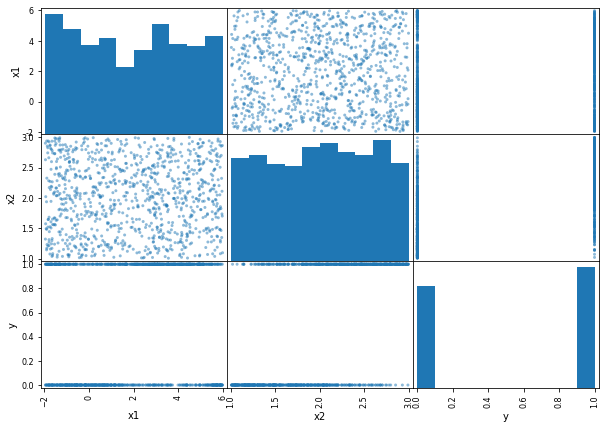

In [ ]:
# Plotting the scatter matrix from our DataFrame
pd.plotting.scatter_matrix(df, figsize=(10,7))
plt.show()

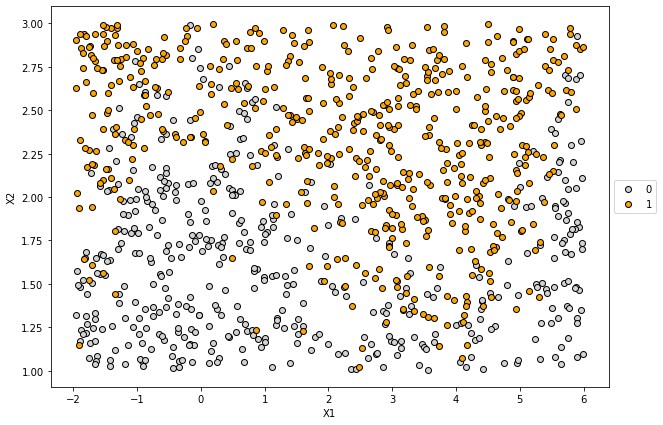

In [ ]:
# Converting independent variables to numpy array for plotting
x1 = np.array(df['x1'])
x2 = np.array(df['x2'])
# colors for different classes
color_map = {1: 'orange', 0: 'lightgrey'}

# Scatter plot of y with the two independent variables
plt.figure(figsize=(10,7))
for val in np.unique(df['y']):
    i = np.where(df['y'] == val)
    plt.scatter(x1[i], x2[i], edgecolors='k', label=str(val), color=color_map[val]) 
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(loc='center left',
           bbox_to_anchor=(1, 0.5))
plt.show()

> From the *scatter matrix* and the *scatter plot* it is clear that this dataset is **not suitable** for classification using a **Linear model** as both the independent variables `x1` and `x2` do not have a linear relation with the dependent variable `y`. The pairwise correlation obtained from `df.corr()` also shows the same. 

> Hence, classifying the above plot using a straight line will result in poor classification accuracy.

### Classification using MLP Classifier

Using GridSearchCV with MLP Classifer to train and find the best values of alpha

In [ ]:
## Importing required packages

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

**Creating train-test splits**

In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((800, 2), (800,), (200, 2), (200,))

**Creating a parameter grid for the GridSearchCV on our MLP Classifier**

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['sgd', 'adam'], # Not including 'lfgs' as the dataset is large, also I was getting convergence warning even after max_iter = 3000
    'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.5, 2],
    'max_iter': [1500] # Changing this as I was getting ConvergenceWarning for sgd.
}

> Normalizing the independent variables within a pipeline during `GridSearchCV` to **prevent data leakage**.

In [ ]:
model = MLPClassifier()

clf = GridSearchCV(estimator = model,
                   param_grid = param_grid,
                   n_jobs = -1) # Performs 5-fold cross validation by default.

sc = StandardScaler()

# Creating pipeline for scaling data with GridSearchCV
pipeline = Pipeline([('transformer', sc), ('estimator', clf)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer', StandardScaler()),
                ('estimator',
                 GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
                              param_grid={'activation': ['relu', 'tanh'],
                                          'alpha': [0.0001, 0.0005, 0.001,
                                                    0.005, 0.01, 0.05, 0.1, 0.5,
                                                    1, 1.5, 2],
                                          'hidden_layer_sizes': [(100,)],
                                          'max_iter': [1500],
                                          'solver': ['sgd', 'adam']}))])

In [ ]:
# Checking best parameters
clf.best_params_

{'activation': 'relu',
 'alpha': 0.005,
 'hidden_layer_sizes': (100,),
 'max_iter': 1500,
 'solver': 'adam'}

In [ ]:
# Getting the best parameters
alpha = clf.best_params_['alpha']
activation = clf.best_params_['activation']
hidden_layer_size = clf.best_params_['hidden_layer_sizes']
max_iter = clf.best_params_['max_iter']
solver = clf.best_params_['solver']

# Normalizing the independent variables
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Training MLPClassifier with the best parameters
tuned_model = MLPClassifier(alpha = alpha,
                      hidden_layer_sizes = hidden_layer_size,
                      activation = activation,
                      solver = solver,
                      max_iter = max_iter)

tuned_model.fit(X_train_std, y_train)

MLPClassifier(alpha=0.005, max_iter=1500)

In [ ]:
# Making predictions on test dataset
y_pred_tuned = tuned_model.predict(X_test_std)

### Evaluating our model

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Creating a function to print the model evaluation results
def evaluate_model(model, y_true, y_pred, title):
  print(f'\n***** {title} *****')
  print(f'\nClassification report: \n{classification_report(y_true, y_pred)}')
  print(f'\nAccuracy score: {accuracy_score(y_true, y_pred)}')
  print(f'\nF1 score: {f1_score(y_true, y_pred)}')
  
  print('\n Confusion Matrix: \n')
  fig, ax = plt.subplots(figsize=(10, 10))
  cm = confusion_matrix(y_true, y_pred)
  cmd = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_).plot(ax=ax)
  plt.grid(False)
  plt.show()                               


***** Evaliation for Model with alpha = 0.005 *****

Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       100
           1       0.84      0.89      0.86       100

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200


Accuracy score: 0.86

F1 score: 0.8640776699029127

 Confusion Matrix: 



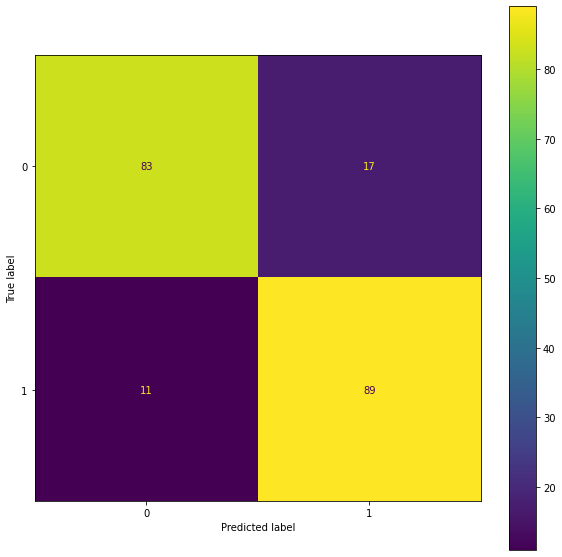

In [ ]:
evaluate_model(tuned_model, y_test, y_pred_tuned, title=f'Evaliation for Model with alpha = {alpha}')

### Training model on a high alpha value (20)

In [ ]:
# Changing the alpha value from the previous model
high_alpha_model = MLPClassifier(alpha = 20,
                      hidden_layer_sizes = hidden_layer_size,
                      activation = activation,
                      solver = solver,
                      max_iter = max_iter)

high_alpha_model.fit(X_train_std, y_train)

MLPClassifier(alpha=20, max_iter=1500)

In [ ]:
y_pred_high_alpha = high_alpha_model.predict(X_test_std)


***** Evaliation for Model with high alpha = 20 *****

Classification report: 
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       100
           1       0.78      0.87      0.82       100

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200


Accuracy score: 0.81

F1 score: 0.820754716981132

 Confusion Matrix: 



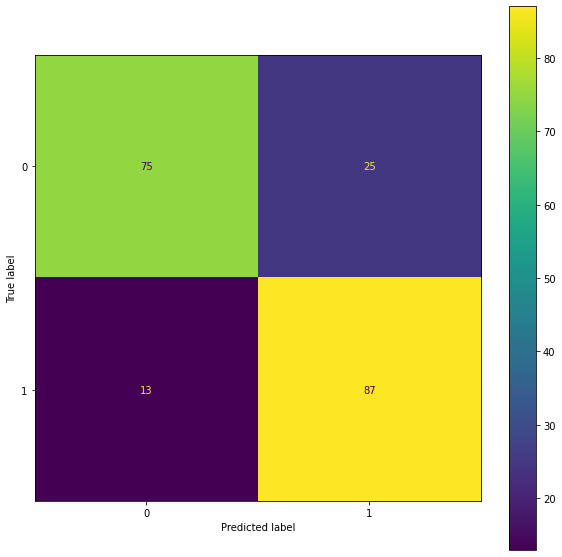

In [ ]:
evaluate_model(high_alpha_model, y_test, y_pred_high_alpha, title='Evaliation for Model with high alpha = 20')

> As we can clearly see, model with **high alpha (20)** has a low **f1 score** and a low **accuracy score**. The confusion matrix also shows that the predictions of model with `alpha=0.01` are better as compared to the model with `alpha=20`

### Visualizing predictions

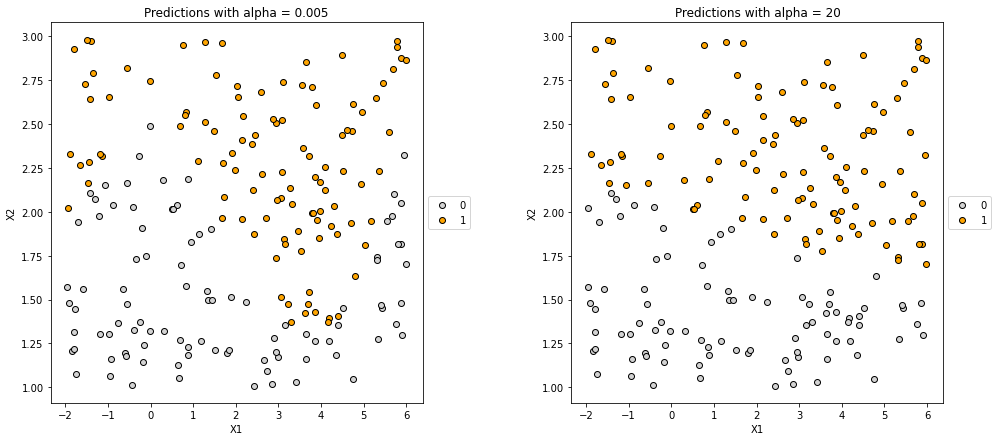

In [ ]:
# Converting independent variables to numpy array for plotting
x1_test_arr = np.array(X_test['x1'])
x2_test_arr = np.array(X_test['x2'])
# colors for different classes
color_map = {1: 'orange', 0: 'lightgrey'}

# Scatter plot of y with the two independent variables
plt.figure(figsize=(16,7))
plt.subplots_adjust(wspace=0.4)

# for lower alpha
plt.subplot(1,2,1)
for val in np.unique(y_pred_tuned):
    i = np.where(y_pred_tuned == val)
    plt.scatter(x1_test_arr[i], x2_test_arr[i], edgecolors='k', label=str(val), color=color_map[val]) 
plt.xlabel('X1')
plt.ylabel('X2')
plt.title(f'Predictions with alpha = {alpha}')
plt.legend(loc='center left',
           bbox_to_anchor=(1, 0.5))

# for alpha = 20
plt.subplot(1,2,2)
for val in np.unique(y_pred_high_alpha):
    i = np.where(y_pred_high_alpha == val)
    plt.scatter(x1_test_arr[i], x2_test_arr[i], edgecolors='k', label=str(val), color=color_map[val]) 
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Predictions with alpha = 20')
plt.legend(loc='center left',
           bbox_to_anchor=(1, 0.5))
plt.show()

**Scatter plot for different alpha values**

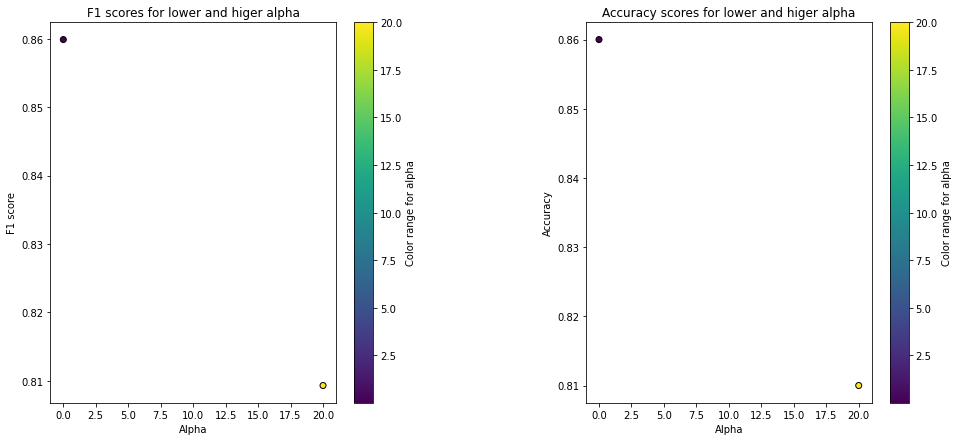

In [ ]:
# Getting data into lists for plotting

alphas = [alpha, 20]
f1scores = [f1_score(y_test, y_pred_tuned, average='weighted'), f1_score(y_test, y_pred_high_alpha, average='weighted')]
accuracy = [accuracy_score(y_test, y_pred_tuned), accuracy_score(y_test, y_pred_high_alpha)]

# Scatter plot
plt.figure(figsize=(16,7))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1,2,1)
plt.scatter(alphas, f1scores, cmap='viridis', c=[alpha, 20], edgecolor='k')
cbar = plt.colorbar()
cbar.set_label('Color range for alpha')
plt.title('F1 scores for lower and higer alpha')
plt.xlabel('Alpha')
plt.ylabel('F1 score')
plt.subplot(1,2,2)
plt.scatter(alphas, accuracy, cmap='viridis', c=[alpha, 20], edgecolor='k')
cbar = plt.colorbar()
cbar.set_label('Color range for alpha')
plt.title('Accuracy scores for lower and higer alpha')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()

**Plotting Loss Curves for different alpha values**

> Loss is the penalty for bad predictions, so we can plot the loss curves of both the models to see the convergence.

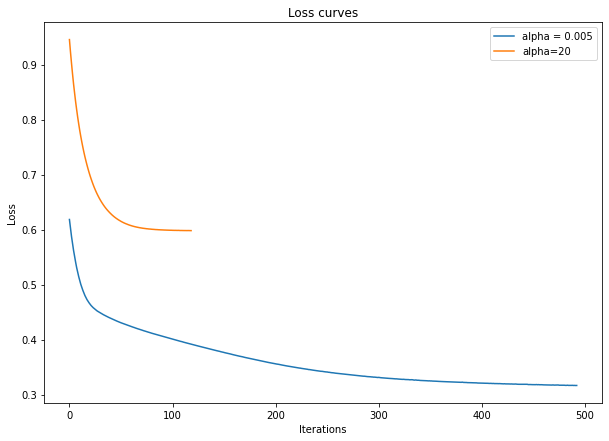

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(tuned_model.loss_curve_, label=f'alpha = {alpha}')
plt.plot(high_alpha_model.loss_curve_, label='alpha=20')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss curves')
plt.show()

> It is clearly seen that the model with **low** alpha  shows better convergence.

### Conclusion

- The classifer with **low** alpha has an **high accuracy** and a better **f1 score** as compared to the higher alpha. So the **lower alpha model** will be able to better correctly identify classes and its mean of precision and recall is better than the **high alpha model**.

- Alpha is a parameter for regularization term that prevents overfitting by constraining the size of the weights.

- High alpha values may fix high variance by encouraging smaller weights but leads to overfitting of the model. Similarly, decreasing alpha may fix high bias by encouraging larger weights but leads to underfitting the model.

- Thus, the high model overfits the train set. This can also be seen in the loss curves above where the model's loss stops decreasing after some iterations as compared to the low alpha model which converges much better.

### References

Matplotlib (2012). Matplotlib: Python plotting — Matplotlib 3.1.1 documentation. [online] Matplotlib.org. Available at: https://matplotlib.org/.


scikit-learn.org. (n.d.). scikit-learn: machine learning in Python — scikit-learn 0.22.2 documentation. [online] Available at: https://scikit-learn.org.

            
Numpy (2009). NumPy. [online] Numpy.org. Available at: https://numpy.org/.